# Airocean Parameters Builder

This notebook computes the values defining the faces of the Airocean's unfolded net as well as matrices to get to the target Airocean space from coordinates of the unit icosahedron model.
The matrix for switching from vertical to horizontal layout of the airocean space is also computed here.

C++ code that you can plug directly into the airocean source file is generated at the end of this notebook. 

This notebook includes visualizations that requires geopandas and matplotlib extensions to be installed.


First we import a few packages:

In [11]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import json

Here we define vertices of the unfolded net:

In [12]:
# Icosahedron properties
circumscribed_radius = 1
inscribed_radius = 3**0.5 / 12 * (3 + 5**0.5)
triangle_edge = circumscribed_radius / np.sin(2 * np.pi / 5)
triangle_height = 3**0.5 / 2 * triangle_edge

# Icosahedron properties scaled to a specifi radius. Left to 1.0
radius = 1.0
triangle_earth_edge = triangle_edge * radius
triangle_earth_height = triangle_height * radius
circumscribed_earth_radius = circumscribed_radius * radius
inscribed_earth_radius = inscribed_radius * radius


# Vertices of the faces in the airocean referential
airocean_vertices = np.array(
    [
        [2, 0, 0],  # Vertex 0
        [1, 1, 0],  # Vertex 1
        [3, 1, 0],  # Vertex 2
        [0, 2, 0],  # Vertex 3
        [2, 2, 0],  # Vertex 4
        [1, 3, 0],  # Vertex 5
        [3, 3, 0],  # Vertex 6
        [0, 4, 0],  # Vertex 7
        [2, 4, 0],  # Vertex 8
        [1, 5, 0],  # Vertex 9
        [3, 5, 0],  # Vertex 10
        [0, 6, 0],  # Vertex 11
        [2, 6, 0],  # Vertex 12
        [1, 7, 0],  # Vertex 13
        [3, 7, 0],  # Vertex 14
        [0, 8, 0],  # Vertex 15
        [2, 8, 0],  # Vertex 16
        [1, 9, 0],  # Vertex 17
        [3, 9, 0],  # Vertex 18
        [0, 10, 0],  # Vertex 19
        [2, 10, 0],  # Vertex 20
        [1, 11, 0],  # Vertex 21
        [0.5, 9.5, 0],  # Vertex 22 : Split from Face 15 (ocean)
        [1, 0, 0],  # Vertex 23 : Split from Face 15 (australia)
        [2 / 3, 8, 0],  # Vertex 24 : split from face 8 (japan)
        [1 / 3, 7, 0],  # Vertex 25 : new from face 8 (japan)
        [1, -1, 0],  # Vertex 26 : bottom new for antartica
    ]
) * [triangle_earth_height, triangle_earth_edge / 2, 1]

We build airocean unsplited faces from the previous vertices:

In [13]:
airocean_face_vertices = airocean_vertices[
    [
        [12, 16, 14],  # Face 0
        [12, 13, 16],  # Face 1
        [12, 9, 13],  # Face 2
        [12, 8, 9],  # Face 3
        [12, 14, 10],  # Face 4
        [14, 16, 18],  # Face 5
        [20, 16, 17],  # Face 6
        [17, 16, 13],  # Face 7
        [9, 11, 13],  # Face 9
        [9, 5, 7],  # Face 10
        [9, 8, 5],  # Face 11
        [5, 8, 4],  # Face 12
        [4, 8, 6],  # Face 13
        [0, 4, 2],  # Face 14
        [19, 17, 15],  # Face 16
        [3, 7, 5],  # Face 17
        [1, 5, 4],  # Face 18
        [1, 4, 0],  # Face 19
        [15, 17, 13],  # Face 8
        [19, 21, 17],  # Face 15
        [26, 1, 0],  # Face 8'
        [11, 15, 13],  # Face 15'
    ]
]
airocean_face_vertices = np.concat(
    [
        airocean_face_vertices,
        np.zeros((*airocean_face_vertices.shape[:-1], 1)),
    ],
    axis=2,
)

airocean_22_centers = airocean_face_vertices.mean(axis=1)
airocean_22_centers[:, 2] = 1
airocean_2_centers = airocean_22_centers[[18, 19]]

Quick visualization of airocean enumerated faces:

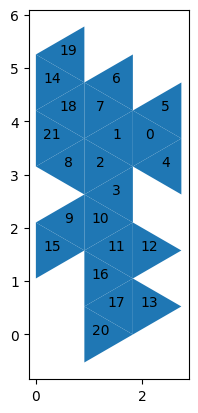

In [14]:
gdf = gpd.GeoDataFrame(
    data={"id": range(22)},
    geometry=[Polygon(shell=v[:, :2]) for v in airocean_face_vertices],
    crs=None,
)
ax = gdf.plot()
gdf.apply(
    lambda x: ax.annotate(
        text=x["id"], xy=x.geometry.centroid.coords[0], ha="center"
    ),
    axis=1,
)
pass

The airocean unfolded net faces are not all base triangles. Some are actually broken into more faaces. We take those extra faces into account by computimg them here: 

In [15]:
airocean_23_face_vertices = airocean_vertices[
    [
        [12, 16, 14],  # Face 0
        [12, 13, 16],  # Face 1
        [12, 9, 13],  # Face 2
        [12, 8, 9],  # Face 3
        [12, 14, 10],  # Face 4
        [14, 16, 18],  # Face 5
        [20, 16, 17],  # Face 6
        [17, 16, 13],  # Face 7
        [9, 11, 13],  # Face 9
        [9, 5, 7],  # Face 10
        [9, 8, 5],  # Face 11
        [5, 8, 4],  # Face 12
        [4, 8, 6],  # Face 13
        [0, 4, 2],  # Face 14
        [19, 17, 15],  # Face 16
        [3, 7, 5],  # Face 17
        [1, 5, 4],  # Face 18
        [1, 4, 0],  # Face 19
        # [15, 17, 13],  # Face 8
        # [19, 21, 17],  # Face 15
        [17, 22, 21],  # Face 20 - from 15 (Ocean)
        [1, 0, 23],  # Face 21 - from 15 (Australia)
        [15, 17, 24],  # Face 22 - from 8 (Japan)
        [17, 13, 24],  # Face 23 - from 8 (Japan)
        [11, 25, 13],  # Face 24 - from 8 (Japan)
    ]
]
airocean_23_face_vertices = np.concat(
    [
        airocean_23_face_vertices,
        np.ones((*airocean_23_face_vertices.shape[:-1], 1)),
    ],
    axis=2,
)
airocean_23_face_vertices[:, :, 3] = 1.0


airocean_23_centers = airocean_23_face_vertices.mean(axis=1)
airocean_23_centers[:, 2] = 1

We now visualize an enumeration of the final unfolded faces of the airocean unfolded net

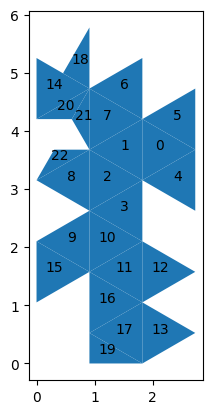

In [16]:
gdf = gpd.GeoDataFrame(
    data={"id": range(len(airocean_23_face_vertices))},
    geometry=[Polygon(shell=v[:, :2]) for v in airocean_23_face_vertices],
    crs=None,
)
ax = gdf.plot()
gdf.apply(
    lambda x: ax.annotate(
        text=x["id"], xy=x.geometry.centroid.coords[0], ha="center"
    ),
    axis=1,
)
pass

We compute the transform matrix and its inverse to switch from vertical airocean layoout to the horizontal one. 

In [17]:
def translation(dx=0, dy=0):
    res = np.eye(4)
    res[[0, 1], 3] = dx, dy
    return res


def rotation(angle):
    res = np.eye(4)
    res[:2, :2] = np.round(
        [
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)],
        ],
        10,
    )
    return res


w, h = airocean_vertices[:, 0].max(), airocean_vertices[:, 1].max()
lower_left = [0, 0, 0, 1]
lower_right = [w, 0, 0, 1]
upper_left = [0, h, 0, 1]
upper_right = [w, h, 0, 1]

translation(h, 0) @ rotation(np.pi / 2 * 1) @ lower_left
translation(h, 0) @ rotation(np.pi / 2 * 1) @ lower_right
translation(h, 0) @ rotation(np.pi / 2 * 1) @ upper_left
translation(h, 0) @ rotation(np.pi / 2 * 1) @ upper_right
orient_horizontal = translation(h, 0) @ rotation(np.pi / 2 * 1)

inv_orient_horizontal = np.linalg.inv(orient_horizontal)

Here we define the icosahedron vertices values.

We also define the 20 centers of those faces.

And we also define centers for the faces corresponding to the broken/split faces in the final airocean unfolded net.

In [18]:
ico_faces = np.array(
    [
        [
            [0.42015243, 0.07814525, 0.90408255, 1.0],
            [0.51883673, 0.83542038, 0.18133184, 1.0],
            [0.99500944, -0.0913478, 0.04014718, 1.0],
        ],
        [
            [0.42015243, 0.07814525, 0.90408255, 1.0],
            [-0.41468223, 0.65596241, 0.63067581, 1.0],
            [0.51883673, 0.83542038, 0.18133184, 1.0],
        ],
        [
            [0.42015243, 0.07814525, 0.90408255, 1.0],
            [-0.51545596, -0.3817169, 0.76720099, 1.0],
            [-0.41468223, 0.65596241, 0.63067581, 1.0],
        ],
        [
            [0.42015243, 0.07814525, 0.90408255, 1.0],
            [0.3557814, -0.84358, 0.40223423, 1.0],
            [-0.51545596, -0.3817169, 0.76720099, 1.0],
        ],
        [
            [0.42015243, 0.07814525, 0.90408255, 1.0],
            [0.99500944, -0.0913478, 0.04014718, 1.0],
            [0.3557814, -0.84358, 0.40223423, 1.0],
        ],
        [
            [0.99500944, -0.0913478, 0.04014718, 1.0],
            [0.51883673, 0.83542038, 0.18133184, 1.0],
            [0.51545596, 0.3817169, -0.76720099, 1.0],
        ],
        [
            [0.51545596, 0.3817169, -0.76720099, 1.0],
            [0.51883673, 0.83542038, 0.18133184, 1.0],
            [-0.3557814, 0.84358, -0.40223423, 1.0],
        ],
        [
            [-0.3557814, 0.84358, -0.40223423, 1.0],
            [0.51883673, 0.83542038, 0.18133184, 1.0],
            [-0.41468223, 0.65596241, 0.63067581, 1.0],
        ],
        [
            [-0.51545596, -0.3817169, 0.76720099, 1.0],
            [-0.99500944, 0.0913478, -0.04014718, 1.0],
            [-0.41468223, 0.65596241, 0.63067581, 1.0],
        ],
        [
            [-0.51545596, -0.3817169, 0.76720099, 1.0],
            [-0.51883673, -0.83542038, -0.18133184, 1.0],
            [-0.99500944, 0.0913478, -0.04014718, 1.0],
        ],
        [
            [-0.51545596, -0.3817169, 0.76720099, 1.0],
            [0.3557814, -0.84358, 0.40223423, 1.0],
            [-0.51883673, -0.83542038, -0.18133184, 1.0],
        ],
        [
            [-0.51883673, -0.83542038, -0.18133184, 1.0],
            [0.3557814, -0.84358, 0.40223423, 1.0],
            [0.41468223, -0.65596241, -0.63067581, 1.0],
        ],
        [
            [0.41468223, -0.65596241, -0.63067581, 1.0],
            [0.3557814, -0.84358, 0.40223423, 1.0],
            [0.99500944, -0.0913478, 0.04014718, 1.0],
        ],
        [
            [0.51545596, 0.3817169, -0.76720099, 1.0],
            [0.41468223, -0.65596241, -0.63067581, 1.0],
            [0.99500944, -0.0913478, 0.04014718, 1.0],
        ],
        [
            [-0.42015243, -0.07814525, -0.90408255, 1.0],
            [-0.3557814, 0.84358, -0.40223423, 1.0],
            [-0.99500944, 0.0913478, -0.04014718, 1.0],
        ],
        [
            [-0.42015243, -0.07814525, -0.90408255, 1.0],
            [-0.99500944, 0.0913478, -0.04014718, 1.0],
            [-0.51883673, -0.83542038, -0.18133184, 1.0],
        ],
        [
            [-0.42015243, -0.07814525, -0.90408255, 1.0],
            [-0.51883673, -0.83542038, -0.18133184, 1.0],
            [0.41468223, -0.65596241, -0.63067581, 1.0],
        ],
        [
            [-0.42015243, -0.07814525, -0.90408255, 1.0],
            [0.41468223, -0.65596241, -0.63067581, 1.0],
            [0.51545596, 0.3817169, -0.76720099, 1.0],
        ],
        [
            [-0.3557814, 0.84358, -0.40223423, 1.0],
            [-0.38796691, 0.38271738, -0.65315839, 1.0],
            [0.51545596, 0.3817169, -0.76720099, 1.0],
        ],
        [
            [-0.42015243, -0.07814525, -0.90408255, 1.0],
            [0.51545596, 0.3817169, -0.76720099, 1.0],
            [-0.38796691, 0.38271738, -0.65315839, 1.0],
        ],
        [
            [-0.99500944, 0.0913478, -0.04014718, 1.0],
            [-0.3557814, 0.84358, -0.40223423, 1.0],
            [-0.58849102, 0.53029673, 0.0627648, 1.0],
        ],
        [
            [-0.3557814, 0.84358, -0.40223423, 1.0],
            [-0.41468223, 0.65596241, 0.63067581, 1.0],
            [-0.58849102, 0.53029673, 0.0627648, 1.0],
        ],
        [
            [-0.99500944, 0.0913478, -0.04014718, 1.0],
            [-0.58849102, 0.53029673, 0.0627648, 1.0],
            [-0.41468223, 0.65596241, 0.63067581, 1.0],
        ],
    ]
)
ico_20_centers = np.array(
    [
        [0.6446662, 0.27407261, 0.37518719],
        [0.17476898, 0.52317601, 0.57203007],
        [-0.16999525, 0.11746359, 0.76731978],
        [0.08682596, -0.38238388, 0.69117259],
        [0.59031442, -0.28559418, 0.44882132],
        [0.67643404, 0.37526316, -0.18190733],
        [0.22617043, 0.68690576, -0.32936779],
        [-0.08387563, 0.77832093, 0.13659114],
        [-0.64171587, 0.12186443, 0.45257654],
        [-0.67643404, -0.37526316, 0.18190733],
        [-0.22617043, -0.68690576, 0.32936779],
        [0.08387563, -0.77832093, -0.13659114],
        [0.58849102, -0.53029673, -0.0627648],
        [0.64171587, -0.12186443, -0.45257654],
        [-0.59031442, 0.28559418, -0.44882132],
        [-0.6446662, -0.27407261, -0.37518719],
        [-0.17476898, -0.52317601, -0.57203007],
        [0.16999525, -0.11746359, -0.76731978],
        [-0.58849102, 0.53029673, 0.0627648],
        [-0.08682596, 0.38238388, -0.69117259],
    ]
)
# Centers corresponding to the split faces of Australia
ico_2_centers = np.array(
    [
        [-0.07609745, 0.53600476, -0.6075312],
        [-0.09755446, 0.22876301, -0.77481398],
    ]
)
# Centers corresponding to the split faces around Japan
ico_3_centers = np.array(
    [
        [-0.64642729, 0.48840818, -0.12653887],
        [-0.45298488, 0.67661305, 0.09706879],
        [-0.66606089, 0.42586898, 0.21776448],
    ]
)

Here we compute the transform matrices from each icosahedron face to their corresponding face in airocean space.

We do so for each face by inverting the matrice that maps the 3 corner of a face and a point elevated from the center of the face to their corresponding target projection.

Assertions are made to check if each matrix and their corresponding inverse work as intended back and forth.

In [19]:
A = ico_faces[:, 1] - ico_faces[:, 0]
B = ico_faces[:, 2] - ico_faces[:, 0]
ico_normals = -np.array(
    [
        A[:, 1] * B[:, 2] - A[:, 2] * B[:, 1],
        A[:, 2] * B[:, 0] - A[:, 0] * B[:, 2],
        A[:, 0] * B[:, 1] - A[:, 1] * B[:, 0],
    ]
).T
ico_normals /= ((ico_normals**2).sum(axis=1) ** 0.5).reshape(-1, 1)
ico_centers = ico_faces.mean(axis=1)
ico_elevated_centers = ico_centers.copy()
ico_elevated_centers[:, :3] += ico_normals

airocean_basis = np.zeros((23, 4, 4))
airocean_basis[:, :3, :] = airocean_23_face_vertices[:, :3, :]
airocean_basis[:, 3, :] = airocean_23_centers

ico_basis = np.zeros((23, 4, 4))
ico_basis[:, :3, :] = ico_faces
ico_basis[:, 3, :] = ico_elevated_centers


air_ico_trans = np.array(
    [
        a.T @ np.linalg.inv(b.T)
        for i, (a, b) in enumerate(zip(ico_basis, airocean_basis))
    ]
)
ico_air_trans = np.array(
    [
        b.T @ np.linalg.inv(a.T)
        for i, (a, b) in enumerate(zip(ico_basis, airocean_basis))
    ]
)

for i, (a, b, v1, v2) in enumerate(
    zip(ico_basis, airocean_basis, ico_centers, airocean_22_centers)
):
    m = b.T @ np.linalg.inv(a.T)  # ico to air
    w = a.T @ np.linalg.inv(b.T)  # air to ico
    for x, y in zip(a, b):
        v1 = m @ x.T
        v1 /= v1[3]
        v2 = w @ y.T
        v2 /= v2[3]
        assert np.isclose(v1, y, rtol=1e-7).all()
        assert np.isclose(v2, x, rtol=1e-7).all()
    for i in range(100):
        r = np.random.rand(3)
        r /= r.sum()
        v = (a[:3, :] * r.reshape(3, 1)).sum(axis=0)
        v1 = m @ v.T
        v1 /= v1[3]
        v2 = w @ v1.T
        v2 /= v2[3]
        assert np.isclose(v, v2, rtol=1e-7).all()

Here we generate C code that can be pasted into the airocean projection source file.

In [20]:
print(
    "\n".join(
        [
            (
                f"{name} = "
                + json.dumps(value.tolist())
                .replace("[", "{")
                .replace("]", "}")
                + ";"
            )
            for name, value in {
                "constexpr pj_face base_ico_faces[23]": ico_faces[:, :, :3],
                "constexpr PJ_XYZ base_ico_centers[23]": ico_centers[:, :3],
                "constexpr PJ_XYZ base_ico_normals[23]": ico_normals,
                "constexpr pj_face base_airocean_faces[23]": airocean_23_face_vertices[
                    :, :, [0, 1, 3]
                ],
                "constexpr double base_ico_air_trans[23][4][4]": ico_air_trans[
                    :, :, :
                ],
                "constexpr double base_air_ico_trans[23][4][4]": air_ico_trans[
                    :, :, :
                ],
                "constexpr double orient_horizontal_trans[4][4]": orient_horizontal,
                "constexpr double orient_horizontal_inv_trans[4][4]": inv_orient_horizontal,
            }.items()
        ]
    )
)

constexpr pj_face base_ico_faces[23] = {{{0.42015243, 0.07814525, 0.90408255}, {0.51883673, 0.83542038, 0.18133184}, {0.99500944, -0.0913478, 0.04014718}}, {{0.42015243, 0.07814525, 0.90408255}, {-0.41468223, 0.65596241, 0.63067581}, {0.51883673, 0.83542038, 0.18133184}}, {{0.42015243, 0.07814525, 0.90408255}, {-0.51545596, -0.3817169, 0.76720099}, {-0.41468223, 0.65596241, 0.63067581}}, {{0.42015243, 0.07814525, 0.90408255}, {0.3557814, -0.84358, 0.40223423}, {-0.51545596, -0.3817169, 0.76720099}}, {{0.42015243, 0.07814525, 0.90408255}, {0.99500944, -0.0913478, 0.04014718}, {0.3557814, -0.84358, 0.40223423}}, {{0.99500944, -0.0913478, 0.04014718}, {0.51883673, 0.83542038, 0.18133184}, {0.51545596, 0.3817169, -0.76720099}}, {{0.51545596, 0.3817169, -0.76720099}, {0.51883673, 0.83542038, 0.18133184}, {-0.3557814, 0.84358, -0.40223423}}, {{-0.3557814, 0.84358, -0.40223423}, {0.51883673, 0.83542038, 0.18133184}, {-0.41468223, 0.65596241, 0.63067581}}, {{-0.51545596, -0.3817169, 0.76720099